In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f26065d8ac8>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


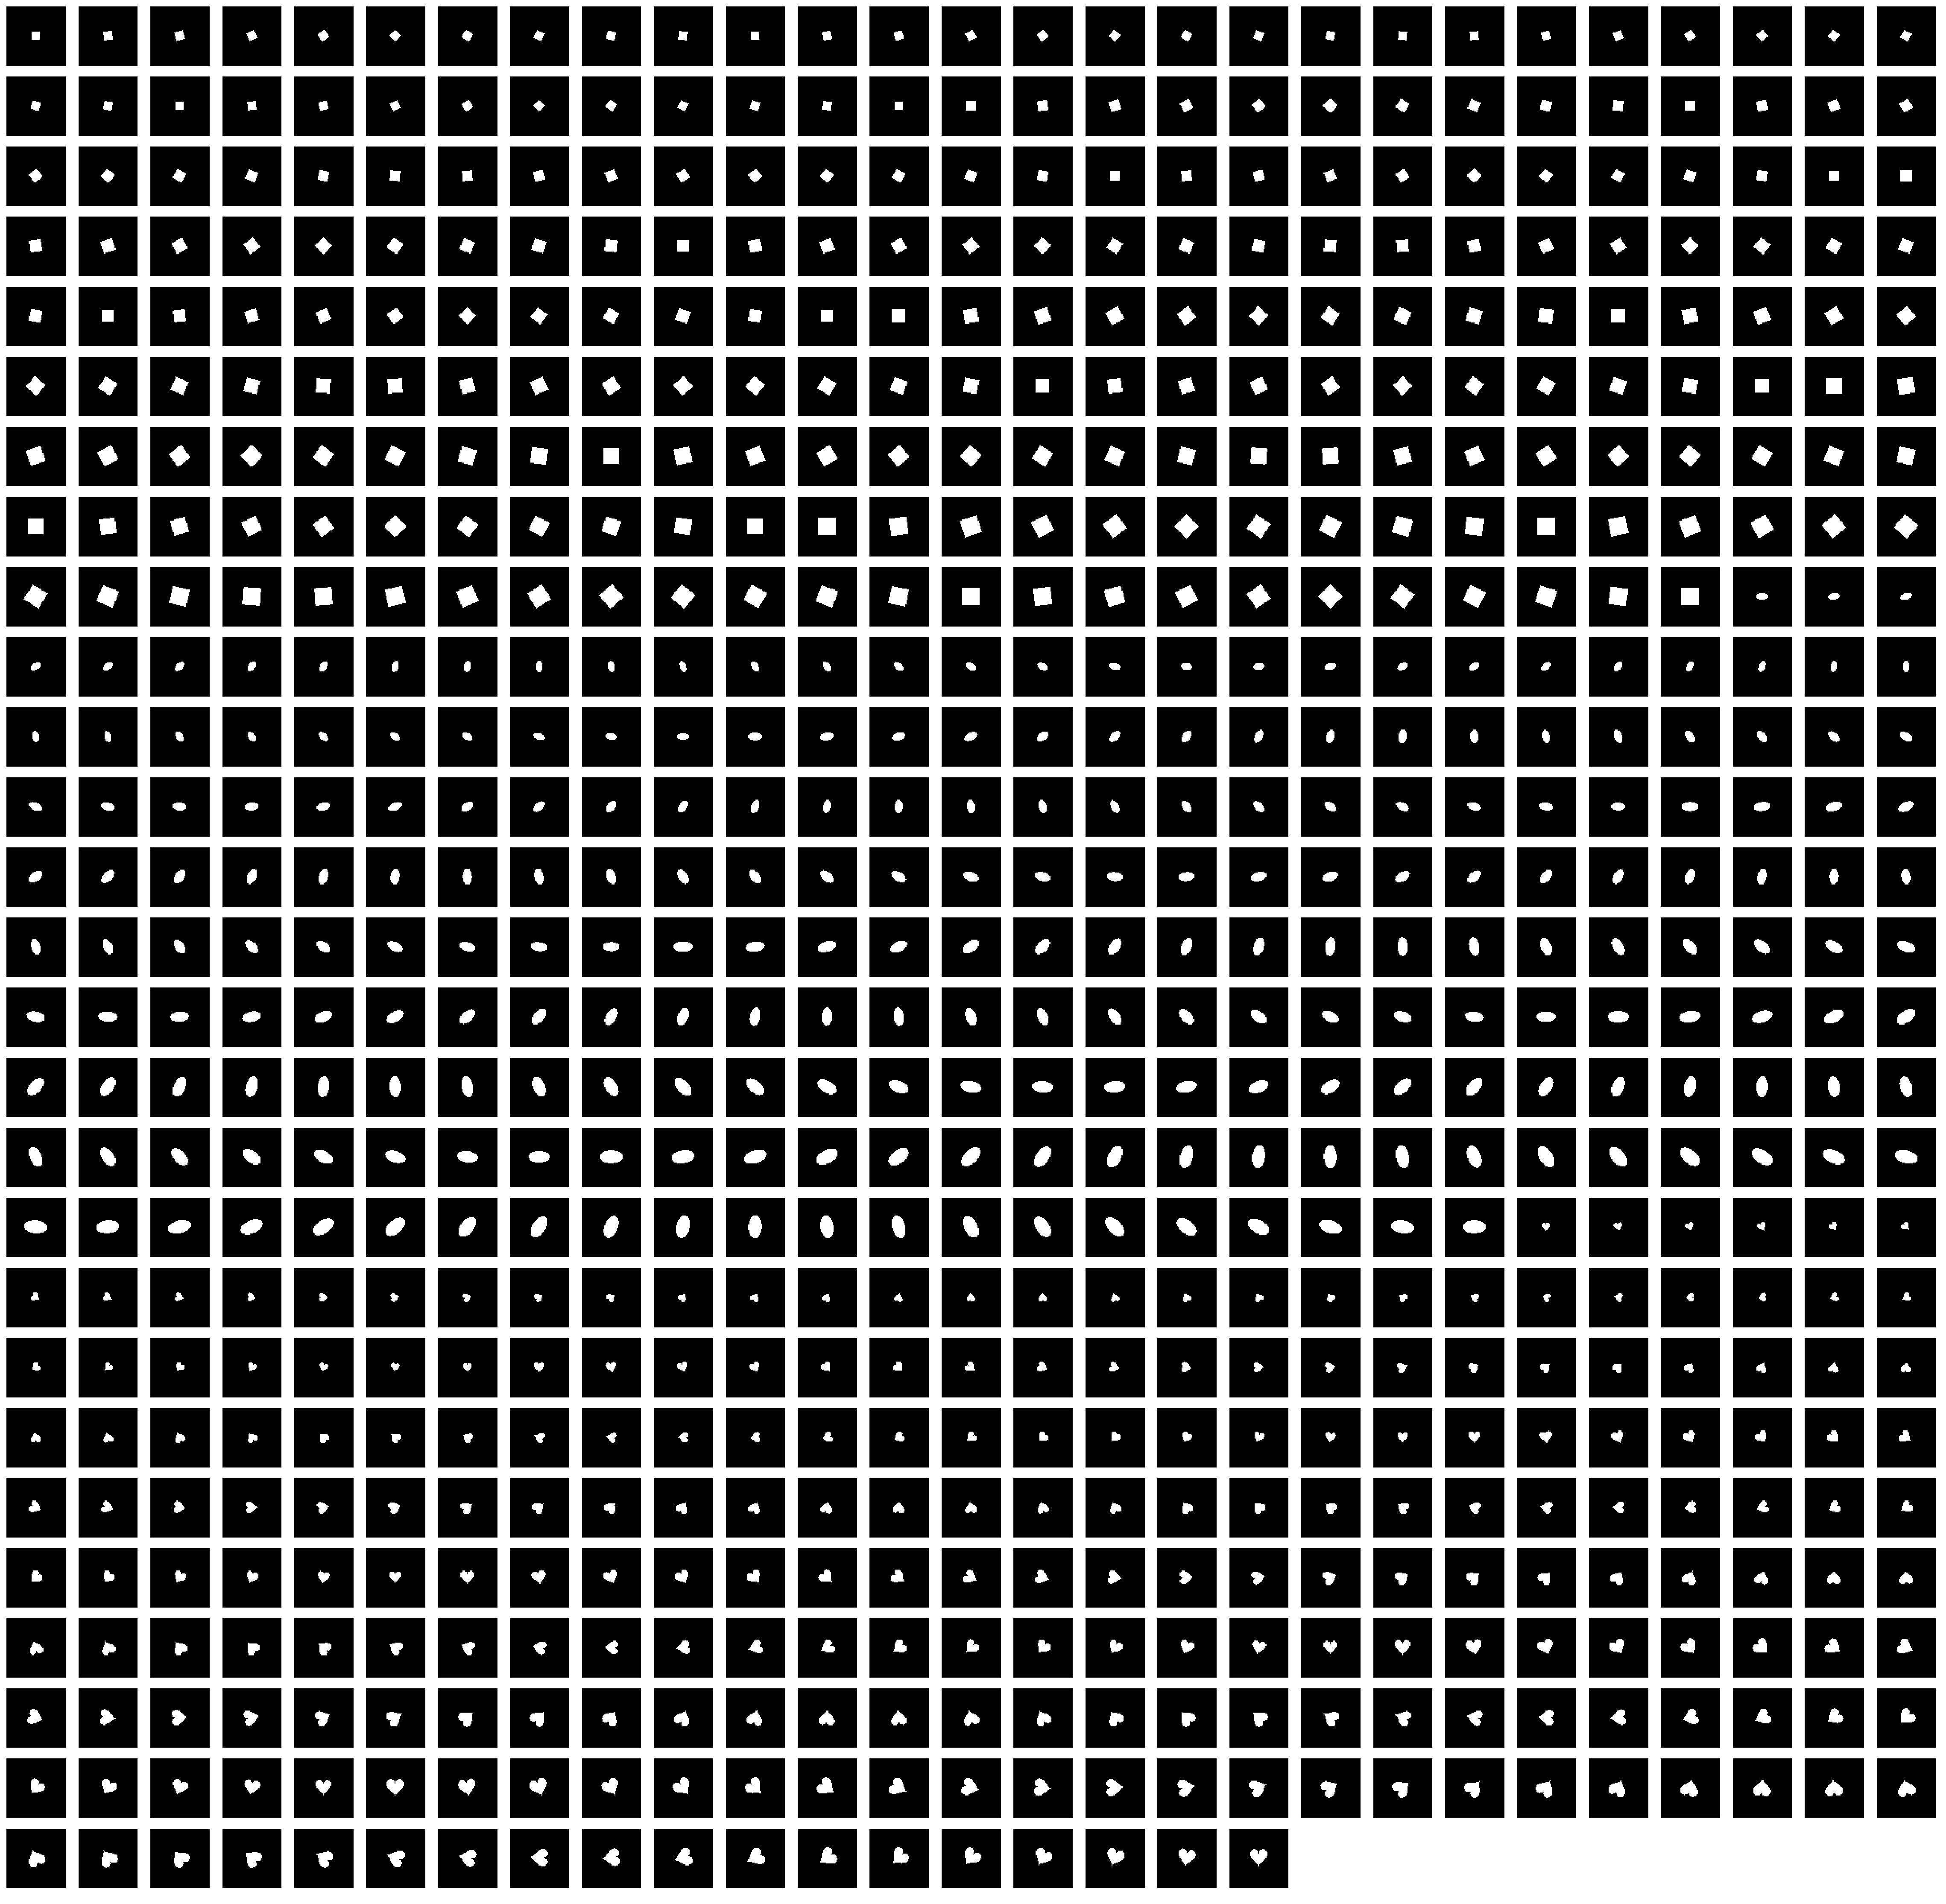

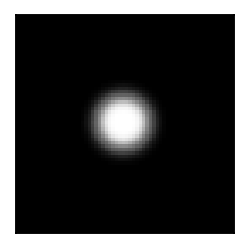

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
#latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

576


In [4]:
ff.shape[0]*0.8
idx_test

array([  1,   3,  13,  14,  15,  18,  20,  22,  23,  29,  32,  47,  56,
        58,  61,  62,  69,  70,  76,  78,  86,  88, 106, 109, 112, 114,
       115, 158, 164, 167, 168, 178, 180, 189, 194, 195, 197, 199, 209,
       219, 220, 224, 225, 229, 237, 238, 240, 242, 244, 252, 253, 256,
       266, 273, 274, 277, 286, 287, 290, 294, 297, 298, 300, 301, 304,
       305, 309, 322, 324, 334, 339, 340, 343, 348, 350, 353, 354, 356,
       359, 363, 369, 376, 379, 380, 382, 385, 390, 402, 409, 414, 420,
       435, 440, 444, 446, 449, 453, 457, 462, 464, 465, 479, 486, 491,
       493, 498, 499, 507, 510, 513, 518, 527, 532, 533, 553, 557, 564,
       565, 570, 585, 587, 595, 596, 597, 598, 602, 605, 616, 625, 633,
       644, 647, 652, 657, 658, 661, 673, 674, 677, 680, 689, 702, 708,
       713])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [6]:
x_train.shape

(576, 4096)

In [7]:
x_test.shape

(144, 4096)

In [8]:
# def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
#     if n is None:
#         n = len(data)    
#     n_rows = int(np.ceil(n / float(n_cols)))
#     figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
#     for k, x in enumerate(data[:n]):
#         r = k // n_cols
#         c = k % n_cols
#         figure[r * img_rows: (r + 1) * img_rows,
#                c * img_cols: (c + 1) * img_cols] = x
#         if thumbnail_cb is not None:
#             thumbnail_cb(locals())
        
#     plt.figure(figsize=(64, 64))
#     plt.imshow(figure)
#     plt.axis("off")
#     plt.tight_layout()
# show_examples(ff, n=100, n_cols=25)

In [9]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [10]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [11]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_x = np.linspace(-2, 2, n)
    
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [12]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 100
latent_dim = 4
epochs = 100

In [13]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [14]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [15]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [16]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [17]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,792
Trainable params: 2,249,792
Non-trainable params: 0
_________________________________________________________________


In [18]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [19]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 2245960   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249792   
Total params: 4,495,752
Trainable params: 4,495,752
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = int(500)

In [21]:
from keras.callbacks import ModelCheckpoint

'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
#model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None), 
        callbacks=[checkpointer])

Train on 576 samples, validate on 144 samples
Epoch 1/500
576/576 [==============================] - 1s 3ms/step - loss: 2650.0252 - val_loss: 1792.0272

Epoch 00001: val_loss improved from inf to 1792.02723, saving model to weights.hdf5
Epoch 2/500
576/576 [==============================] - 0s 118us/step - loss: 974.9678 - val_loss: 312.8502

Epoch 00002: val_loss improved from 1792.02723 to 312.85021, saving model to weights.hdf5
Epoch 3/500
576/576 [==============================] - 0s 117us/step - loss: 255.4061 - val_loss: 238.7501

Epoch 00003: val_loss improved from 312.85021 to 238.75008, saving model to weights.hdf5
Epoch 4/500
576/576 [==============================] - 0s 114us/step - loss: 223.8659 - val_loss: 198.0523

Epoch 00004: val_loss improved from 238.75008 to 198.05230, saving model to weights.hdf5
Epoch 5/500
576/576 [==============================] - 0s 109us/step - loss: 193.3520 - val_loss: 183.2692

Epoch 00005: val_loss improved from 198.05230 to 183.26917, sa

Epoch 45/500
576/576 [==============================] - 0s 117us/step - loss: 101.3073 - val_loss: 108.7840

Epoch 00045: val_loss improved from 109.03658 to 108.78397, saving model to weights.hdf5
Epoch 46/500
576/576 [==============================] - 0s 111us/step - loss: 100.5801 - val_loss: 110.3543

Epoch 00046: val_loss did not improve from 108.78397
Epoch 47/500
576/576 [==============================] - 0s 122us/step - loss: 99.1163 - val_loss: 110.5569

Epoch 00047: val_loss did not improve from 108.78397
Epoch 48/500
576/576 [==============================] - 0s 129us/step - loss: 101.5921 - val_loss: 107.5026

Epoch 00048: val_loss improved from 108.78397 to 107.50261, saving model to weights.hdf5
Epoch 49/500
576/576 [==============================] - 0s 120us/step - loss: 98.7320 - val_loss: 106.5652

Epoch 00049: val_loss improved from 107.50261 to 106.56516, saving model to weights.hdf5
Epoch 50/500
576/576 [==============================] - 0s 119us/step - loss: 98.194

576/576 [==============================] - 0s 136us/step - loss: 83.9961 - val_loss: 107.4583

Epoch 00094: val_loss did not improve from 100.30073
Epoch 95/500
576/576 [==============================] - 0s 131us/step - loss: 84.8189 - val_loss: 122.9353

Epoch 00095: val_loss did not improve from 100.30073
Epoch 96/500
576/576 [==============================] - 0s 135us/step - loss: 83.7923 - val_loss: 110.4399

Epoch 00096: val_loss did not improve from 100.30073
Epoch 97/500
576/576 [==============================] - 0s 136us/step - loss: 82.8738 - val_loss: 117.3565

Epoch 00097: val_loss did not improve from 100.30073
Epoch 98/500
576/576 [==============================] - 0s 136us/step - loss: 83.2026 - val_loss: 108.1563

Epoch 00098: val_loss did not improve from 100.30073
Epoch 99/500
576/576 [==============================] - 0s 137us/step - loss: 84.4010 - val_loss: 106.5847

Epoch 00099: val_loss did not improve from 100.30073
Epoch 100/500
576/576 [========================


Epoch 00144: val_loss did not improve from 98.86980
Epoch 145/500
576/576 [==============================] - 0s 136us/step - loss: 75.0243 - val_loss: 109.9401

Epoch 00145: val_loss did not improve from 98.86980
Epoch 146/500
576/576 [==============================] - 0s 138us/step - loss: 72.9752 - val_loss: 127.6843

Epoch 00146: val_loss did not improve from 98.86980
Epoch 147/500
576/576 [==============================] - 0s 138us/step - loss: 72.9214 - val_loss: 115.7533

Epoch 00147: val_loss did not improve from 98.86980
Epoch 148/500
576/576 [==============================] - 0s 138us/step - loss: 70.7237 - val_loss: 126.8289

Epoch 00148: val_loss did not improve from 98.86980
Epoch 149/500
576/576 [==============================] - 0s 137us/step - loss: 71.1018 - val_loss: 134.0211

Epoch 00149: val_loss did not improve from 98.86980
Epoch 150/500
576/576 [==============================] - 0s 136us/step - loss: 71.0001 - val_loss: 109.4966

Epoch 00150: val_loss did not imp

576/576 [==============================] - 0s 137us/step - loss: 63.6875 - val_loss: 116.6712

Epoch 00195: val_loss did not improve from 95.25562
Epoch 196/500
576/576 [==============================] - 0s 134us/step - loss: 62.9405 - val_loss: 135.9381

Epoch 00196: val_loss did not improve from 95.25562
Epoch 197/500
576/576 [==============================] - 0s 137us/step - loss: 65.2041 - val_loss: 127.3568

Epoch 00197: val_loss did not improve from 95.25562
Epoch 198/500
576/576 [==============================] - 0s 140us/step - loss: 64.9937 - val_loss: 134.1886

Epoch 00198: val_loss did not improve from 95.25562
Epoch 199/500
576/576 [==============================] - 0s 141us/step - loss: 64.0356 - val_loss: 132.3256

Epoch 00199: val_loss did not improve from 95.25562
Epoch 200/500
576/576 [==============================] - 0s 138us/step - loss: 64.2480 - val_loss: 125.0948

Epoch 00200: val_loss did not improve from 95.25562
Epoch 201/500
576/576 [=========================

576/576 [==============================] - 0s 135us/step - loss: 62.1988 - val_loss: 128.1261

Epoch 00246: val_loss did not improve from 92.43546
Epoch 247/500
576/576 [==============================] - 0s 136us/step - loss: 61.4368 - val_loss: 142.3542

Epoch 00247: val_loss did not improve from 92.43546
Epoch 248/500
576/576 [==============================] - 0s 134us/step - loss: 61.2156 - val_loss: 134.0901

Epoch 00248: val_loss did not improve from 92.43546
Epoch 249/500
576/576 [==============================] - 0s 134us/step - loss: 61.2644 - val_loss: 114.1575

Epoch 00249: val_loss did not improve from 92.43546
Epoch 250/500
576/576 [==============================] - 0s 135us/step - loss: 60.0962 - val_loss: 126.2555

Epoch 00250: val_loss did not improve from 92.43546
Epoch 251/500
576/576 [==============================] - 0s 138us/step - loss: 60.5955 - val_loss: 128.8417

Epoch 00251: val_loss did not improve from 92.43546
Epoch 252/500
576/576 [=========================

576/576 [==============================] - 0s 118us/step - loss: 57.5385 - val_loss: 116.8241

Epoch 00297: val_loss did not improve from 92.43546
Epoch 298/500
576/576 [==============================] - 0s 137us/step - loss: 58.4228 - val_loss: 130.6541

Epoch 00298: val_loss did not improve from 92.43546
Epoch 299/500
576/576 [==============================] - 0s 135us/step - loss: 58.4361 - val_loss: 122.1482

Epoch 00299: val_loss did not improve from 92.43546
Epoch 300/500
576/576 [==============================] - 0s 136us/step - loss: 57.2436 - val_loss: 126.1705

Epoch 00300: val_loss did not improve from 92.43546
Epoch 301/500
576/576 [==============================] - 0s 136us/step - loss: 59.4045 - val_loss: 130.7626

Epoch 00301: val_loss did not improve from 92.43546
Epoch 302/500
576/576 [==============================] - 0s 135us/step - loss: 58.5829 - val_loss: 124.7877

Epoch 00302: val_loss did not improve from 92.43546
Epoch 303/500
576/576 [=========================

576/576 [==============================] - 0s 136us/step - loss: 55.7122 - val_loss: 143.4103

Epoch 00348: val_loss did not improve from 92.43546
Epoch 349/500
576/576 [==============================] - 0s 136us/step - loss: 60.0542 - val_loss: 128.7627

Epoch 00349: val_loss did not improve from 92.43546
Epoch 350/500
576/576 [==============================] - 0s 133us/step - loss: 57.8076 - val_loss: 120.2751

Epoch 00350: val_loss did not improve from 92.43546
Epoch 351/500
576/576 [==============================] - 0s 136us/step - loss: 56.7440 - val_loss: 132.9423

Epoch 00351: val_loss did not improve from 92.43546
Epoch 352/500
576/576 [==============================] - 0s 140us/step - loss: 60.0670 - val_loss: 143.3818

Epoch 00352: val_loss did not improve from 92.43546
Epoch 353/500
576/576 [==============================] - 0s 135us/step - loss: 56.9971 - val_loss: 130.1343

Epoch 00353: val_loss did not improve from 92.43546
Epoch 354/500
576/576 [=========================

576/576 [==============================] - 0s 135us/step - loss: 52.4840 - val_loss: 107.3730

Epoch 00399: val_loss did not improve from 92.43546
Epoch 400/500
576/576 [==============================] - 0s 136us/step - loss: 53.3092 - val_loss: 118.6141

Epoch 00400: val_loss did not improve from 92.43546
Epoch 401/500
576/576 [==============================] - 0s 134us/step - loss: 53.0043 - val_loss: 118.0131

Epoch 00401: val_loss did not improve from 92.43546
Epoch 402/500
576/576 [==============================] - 0s 135us/step - loss: 51.9323 - val_loss: 112.7687

Epoch 00402: val_loss did not improve from 92.43546
Epoch 403/500
576/576 [==============================] - 0s 137us/step - loss: 55.7892 - val_loss: 125.8300

Epoch 00403: val_loss did not improve from 92.43546
Epoch 404/500
576/576 [==============================] - 0s 138us/step - loss: 53.6587 - val_loss: 132.9835

Epoch 00404: val_loss did not improve from 92.43546
Epoch 405/500
576/576 [=========================

576/576 [==============================] - 0s 133us/step - loss: 48.5583 - val_loss: 168.9414

Epoch 00450: val_loss did not improve from 92.43546
Epoch 451/500
576/576 [==============================] - 0s 137us/step - loss: 49.3583 - val_loss: 138.5481

Epoch 00451: val_loss did not improve from 92.43546
Epoch 452/500
576/576 [==============================] - 0s 137us/step - loss: 50.3146 - val_loss: 150.4712

Epoch 00452: val_loss did not improve from 92.43546
Epoch 453/500
576/576 [==============================] - 0s 135us/step - loss: 49.3982 - val_loss: 142.5145

Epoch 00453: val_loss did not improve from 92.43546
Epoch 454/500
576/576 [==============================] - 0s 139us/step - loss: 49.0967 - val_loss: 133.1399

Epoch 00454: val_loss did not improve from 92.43546
Epoch 455/500
576/576 [==============================] - 0s 138us/step - loss: 49.1492 - val_loss: 136.9430

Epoch 00455: val_loss did not improve from 92.43546
Epoch 456/500
576/576 [=========================

In [22]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input: 0':x_train})

In [23]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([-0.25983194, -0.11042119, -0.05936022,  0.05178137], dtype=float32)

In [24]:
np.cov(z_output.T)

array([[ 1.00173921e+00,  5.07581361e-09,  1.51973642e-08,
         8.23179494e-08],
       [ 5.07581361e-09,  1.00173924e+00,  1.61635818e-08,
         9.50606681e-09],
       [ 1.51973642e-08,  1.61635818e-08,  1.00173924e+00,
        -3.77420286e-09],
       [ 8.23179494e-08,  9.50606681e-09, -3.77420286e-09,
         1.00173899e+00]])

Plot the Pearson correlation among Z

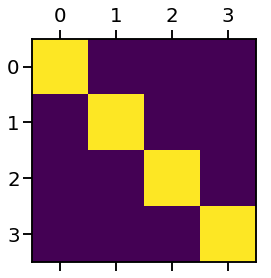

In [25]:
plt.matshow(np.corrcoef(z_output.T))

In [26]:
z_m_m

array([-0.25983194, -0.11042119, -0.05936022,  0.05178137], dtype=float32)

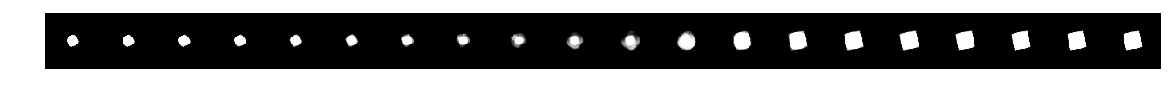

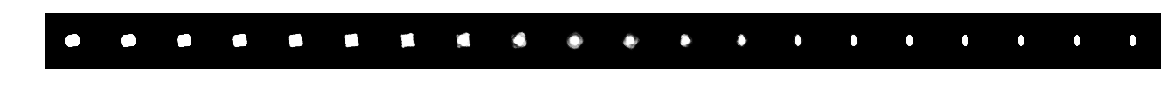

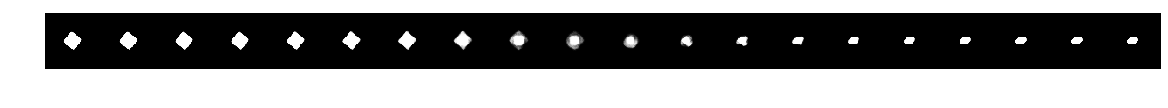

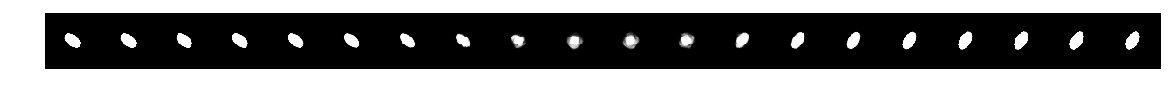

In [27]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")